# Working with posteriors

In the previous lesson, we discussed the workflow for checking that the priors of a model make sense. In this lesson, we focus on the posterior distribution. The posterior-predictive sampling process is very similar to the prior-predictive sampling process but instead of sampling from the prior and then the likelihood, we sample from the posterior and then the likelihood.

The posterior-predictive distribution tells us what the probability is of future data. In the eczema medical trial case study, imagine we were to run a 7th study (the data set contains 6 studies) with $n$ patients. What is our prediction for the number of patients that will improve in either the treatment or control group? The posterior-predictive distribution answers this question.

## Prep plan

* The McElreath reading should take ~1.5 hours.
* This workbook should take ~30 minutes.

## Required reading: Statistical rethinking

Read Sections 3.1–3.3 of McElreath, R. (2020). _Statistical Rethinking, Second Edition_. Chapman and Hall/CRC Press.

* [Publisher's page](https://www.routledge.com/Statistical-Rethinking-A-Bayesian-Course-with-Examples-in-R-and-STAN/McElreath/p/book/9780367139919) for buying the book if you want to
* [The whole book is available online on O'Reilly via the San Francisco Public Library](https://learning-oreilly-com.ezproxy.sfpl.org/library/view/statistical-rethinking-2nd/9780429639142/xhtml/11_Chapter03.xhtml). Log in with your library card number.

**Most of today's pre-class work is reading the textbook.** There is an example and some questions for you to answer below but expect to spend most of your time reading.

### Outline

* **The introduction section is required** (1640 words). The chapter begins by showing how sampling from posterior distributions can make Bayesian inference more intuitive. Instead of working with abstract probabilities and integrals, samples transform problems into frequency-based, countable terms that we often find easier to think about. Sampling also anticipates modern Bayesian computation — many powerful computational algorithms output samples directly, not closed-form posteriors. Learning to use samples early on prepares us to analyze real models later.
* Section 3.1 (_Sampling from a grid-approximate posterior_) is optional (410 words). We don’t cover grid-based sampling since it is a terrible computational technique (extremely slow if you have many variables in your model). However, this is a short section and you might as well read it for continuity.
* **Section 3.2 (_Sampling to summarize_) is required** (3500 words). PyMC helps us to generate samples from the posterior distribution (and other distributions) of a model but it is still our job to interpret those posterior samples. This section goes into detail about the ways we can and should summarize results. Pay particular attention to the _highest posterior density interval (HPDI)_ since we will use it a lot in the rest of the course.
* **Section 3.3 (_Sampling to simulate prediction_) is required** (3330 words). Here, samples are used to generate simulated data (dummy data) from the model. Simulation serves multiple purposes: checking priors, validating software, exploring research design, forecasting, and testing model adequacy. Read it in detail to understand the ways in which posterior-predictive samples can be useful — for making predictions (our focus today) but also for checking the validity of our model (something we’ll get to in a later lesson).

### Terminology for the reading


* The _posterior distribution_ is the distribution over unknown variables (parameters) of the model after incorporating the data set.
* The _posterior-predictive distribution_ is, intuitively, the distribution over the possible future data sets that our model can generate, given the data we have seen already. So, given everything we know so far (including our modeling assumptions and the data), what is our prediction of future observable outcomes?

  In short, the posterior-predictive distribution generates/simulates possible data sets from the fitted model. The fitted model incorporates the data, which is what distinguishes the _posterior_-predictive from the _prior_-predictive distribution which generated possible data sets _without_ conditioning on the real data set.

## Case study: Eczema medical trials

We revisit the medical trial example from the previous session.

### Data

| Study          | TG improved      | TG not improved   | CG improved    | CG not improved   |
|:-------------- | --------:| ------:| ------:| ------:|
| Di Rienzo 2014 | 20       | 3      | 9      | 6      |
| Galli 1994     | 10       | 6      | 11     | 7      |
| Kaufman 1974   | 13       | 3      | 4      | 6      |
| Qin 2014       | 35       | 10     | 21     | 18     |
| Sanchez 2012   | 22       | 9      | 12     | 17     |
| Silny 2006     | 7        | 3      | 0      | 10     |
| **Totals**     | **107**  | **34** | **57** | **64** |
| TG = Treatment group. CG = Control group. [Source](https://www.cochranelibrary.com/cdsr/doi/10.1002/14651858.CD008774.pub2/full) |

### Model

**Likelihood:** $x\sim\text{Binomial}(n,p)$ where $x$ and $n$ are observed variables (data) and $p$ is an unobserved variable (the parameter we want to estimate).

**Prior:** $p\sim\text{Beta}(\alpha=1,\beta=1)$.

**Posterior:** Since we have a conjugate prior–likelihood pair, the posterior is also a Beta distribution, $(p \,|\, s,f)\sim\text{Beta}(\alpha=1 + s,\, \beta=1 + f)$ where $s$ is the number of patients who improved (the successes) and $f$ is the number of patients who did not improve (the failures).

In general, we are not able to solve the posterior analytically and instead we rely on PyMC to generate samples from the posterior. In the code below, you will see that we use samples instead of the closed-form solution.

**Posterior-predictive:** There is also a closed-form solution for this since we have a conjugate prior.

$$(x \mid n,s,f) \sim \text{Beta-Binomial}(n, \alpha=1+s, \beta=1+f)$$

Again, as with the posterior distribution, we won't use the closed-form solution of the posterior-predictive distribution but instead rely on samples from PyMC.

(Optional) Proof outline: The PDF of the Beta-Binomial distribution is the product of the likelihood function and the posterior PDF, with the parameter $p$ integrated out.

$$f_{x \,|\, s,f} = \int_0^1 f_{\text{Binomial}}(x \,|\, n,p)\,f_{\text{Beta}}(p \,|\, 1+s, 1+f) \,\text{d}p$$

$$= \binom{n}{x}\frac{B(x+1+s,n-x+1+f)}{B(1+s,1+f)}$$

We won't go through the proof for the last line. If you're interested, the basic idea is to use the conjugacy of the Beta and Binomial distributions. Watch these two videos for a derivation: [[1](https://www.youtube.com/watch?v=DR_sr23C74A)] [[2](https://www.youtube.com/watch?v=SY8u4vvwG3A)].

## PyMC implementation

**Your task** is to read through, understand, and ask questions about the code below. You should also read the comments — there is useful information in there.

**It is imperative** that you understand the code since we will build on it in class, where you will use the posterior and posterior-predictive samples to answer questions about the medical trial scenario.

In [3]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import pymc as pm


prior_alpha = 1
prior_beta = 1

data = {
    'treatment': {
        'improved': 107,
        'patients': 141},
    'control': {
        'improved': 57,
        'patients': 121}}


def create_model(patients, improved):
    '''
    Create a Beta-Binomial model with the total number of `patients` and the
    number of `improved` patients provided as arguments.
    '''
    with pm.Model() as model:
        # Prior
        p = pm.Beta('p', alpha=prior_alpha, beta=prior_beta)
        # Likelihood
        pm.Binomial('x', n=patients, p=p, observed=improved)
    return model


# Generate posterior and posterior-predictive samples for both groups in the
# data. Notice how we use `pm.sample()` to sample from the posterior and then
# `pm.sample_posterior_predictive` to add the posterior-predictive samples to
# the same `inference` object.
inference = {}
for data_label in data:  # treatment, control
    # Create the model
    model = create_model(
        data[data_label]['patients'], data[data_label]['improved'])
    with model:
        # Sample posterior
        inference[data_label] = pm.sample()
        # Sample posterior-predictive
        pm.sample_posterior_predictive(
            inference[data_label], extend_inferencedata=True)

Output()

Output()

Output()

Output()

In [4]:
print(inference)

{'treatment': Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data, 'control': Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data}


### Plot the posterior distributions

We plot the samples from the approximate posterior as well as the exact solution.

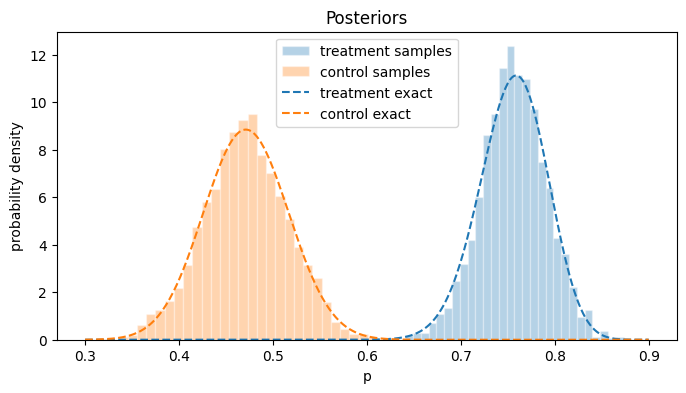

In [2]:
plt.figure(figsize=(8, 4))
plt.title('Posteriors')
plt.xlabel('p')
plt.ylabel('probability density')

# Plot histograms of posterior samples
for i, group in enumerate(inference):
    plt.hist(
        inference[group].posterior.p.values.flatten(), bins=30, density=True,
        color=f'C{i}', edgecolor='white', alpha=0.33, label=group + ' samples')

# Plot the exact posteriors. (We know the posterior is a Beta distribution.)
x = np.linspace(0.3, 0.9, 500)
for i, group in enumerate(inference):
    y = sts.beta.pdf(
        x,
        prior_alpha + data[group]['improved'],
        prior_beta + data[group]['patients'] - data[group]['improved'])
    plt.plot(x, y, f'C{i}--', label=f'{group} exact')

plt.legend()
plt.show()

### Plot the posterior-predictive distributions

We plot the samples from the approximate posterior-predictive as well as the exact posterior-predictive distribution. The Beta-Binomial distribution is discrete so we use dots rather than a line to plot the PMF.

These plots answer the question, what is the probability that $k$ patients would improve if we ran another set of trials with exactly the same number of patients as in the data set?

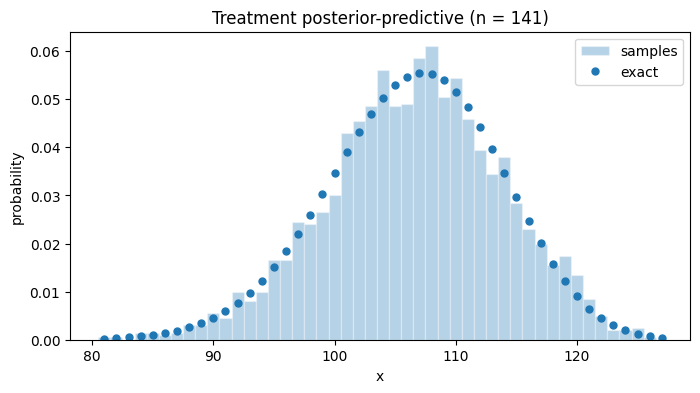

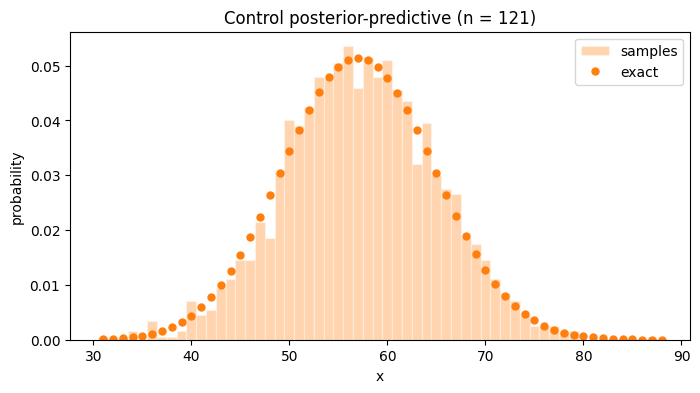

In [3]:
for i, group in enumerate(inference):

    # Plot histograms of posterior-predictive samples
    n = data[group]['patients']
    plt.figure(figsize=(8, 4))
    plt.title(f'{group.title()} posterior-predictive (n = {n})')
    plt.xlabel('x')
    plt.ylabel('probability')
    samples = inference[group].posterior_predictive.x.values.flatten()
    x = np.arange(np.min(samples), np.max(samples) + 2)
    plt.hist(
        samples, bins=x-0.5, density=True, color=f'C{i}', alpha=0.33,
        edgecolor='white', label='samples')

    # Plot the exact posterior-predictive, a Beta-Binomial distribution.
    y = sts.betabinom.pmf(
        x, n, prior_alpha + data[group]['improved'],
        prior_beta + n - data[group]['improved'])
    plt.plot(x, y, f'C{i}.', markersize=10, label='exact')
    plt.legend()

plt.show()

## Questions

Given the plots above, do you think the treatment works or not? Motivate your answer.

In [ ]:
# ADD YOUR ANSWER TO THE PRE-CLASS WORKBOOK ON FORUM